**(on going project)**

## Background

Pneumonia is a form of acute respiratory tract infection that affect the lungs. In 2017, pneumonia killed as many as 808 694 children under the age of 5, accounting for 15% of deaths among children under 5 years of age. Pneumonia can affect people of any age, but children and the elderly, and people with pre-existent health problems are at the most risk of invasive pneumococcal disease (IPD), which is a form of pneumonia where the bacterium *S. pneumoniae* enters the blood. Pneumonia kills more children under five than AIDS, malaria and measles combined. Yet increased attention has been given to the latter diseases.

&nbsp;


### Types of Pneumonia

There are more than 30 different causes of pneumonia, but the most common are bacteria and viruses. 

&nbsp;

### Diagnosis of Pneumonia

It is difficult to differentiate between virial and bacterial pneumonia in resource-poor settings lacking in technology and laboratory equipment

&nbsp;


### Objective

In this work, we are going to train a CNN (Convolutional Neural Network) in order to classify twp classes of chest x-ray images, namely chest x-ray of healh lungs, and lungs affected pneumonia. We will be using Pytorch as our Deep Learning framework.The network architecture consists of a block of convolutional layers followed by relu activations and maxpooling. The features learned by the convolutional layers are then passed through a stack of dense layers, which output raw unnormalized scores. The loss is computed using the [`CrossEntropyLoss()`](https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html) class provided by Pytorch, which combines [`nn.LogSoftmax()`](https://pytorch.org/docs/master/generated/torch.nn.LogSoftmax.html) and `nn.NLLLoss()` in one single class. We also use dropout layers as regularizers and one batch normalization layer. We then evaluate recall, precion and F1-Score, area under the ROC-curve and balanced accuracy.

In [ ]:
# Pytorch imports
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import (DataLoader,
                              Dataset,
                              TensorDataset)

from torch.optim import Adam, RMSprop, SGD
from torchvision import transforms
from torch.utils.data.sampler import WeightedRandomSampler

# Albumentations imports
from albumentations.pytorch import ToTensor
import albumentations as A

# Sklearn metrics imports 
from sklearn.metrics import (f1_score, 
                             recall_score,
                             balanced_accuracy_score,
                             precision_score, 
                             roc_auc_score, 
                             classification_report, 
                             confusion_matrix)

# For showing the confusion matrix
from mlxtend.plotting import plot_confusion_matrix

# Other imports
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from os.path import join
from collections import Counter
import pandas as pd
import seaborn as sns
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Loading and analysing the data

In [0]:
def load_data(dir_path=None):
    class_1, class_0, target = [], [], []
    for filetype in FILETYPE:
        for filename in (filename for filename in os.listdir(join(dir_path, filetype)) if '.jpeg' in filename):
            image = cv2.imread(join(dir_path, filetype, filename))
            image = np.dstack([image]*3) if image.ndim==2 else image
            resized = cv2.resize(image, (224, 224))
            if filetype=="NORMAL":
                class_0.append(resized)
                target.append([1, 0])
            else:
                class_1.append(resized)
                target.append([0, 1])
                 
    return np.vstack([class_0, class_1]), np.array(target)

In [0]:
X_train = np.load('/content/drive/My Drive/data/images_arrays/train_images.npy')
X_test = np.load('/content/drive/My Drive/data/images_arrays/test_images.npy')
X_val = np.load('/content/drive/My Drive/data/images_arrays/val_images.npy')

y_train = np.load('/content/drive/My Drive/data/images_arrays/train_targets.npy')
y_val = np.load('/content/drive/My Drive/data/images_arrays/val_targets.npy')
y_test = np.load('/content/drive/My Drive/data/images_arrays/test_targets.npy')

In [0]:
def visualize_samples(images, rows=1, cols=5, title=None):
    plt.figure(figsize=(2.5*cols, 2.5*rows)).suptitle(title, size=15, color='black')
    idx = np.random.choice(images.shape[0], size=rows*cols)
    for i, sample in enumerate(images[idx]):
        plt.subplot(rows, cols, i+1)
        plt.axis('off')
        plt.imshow(sample)
    plt.show()

visualize_samples(X_train[y_train==0], rows=2, cols=6, title='NORMAL')
visualize_samples(X_train[y_train==1], rows=2, cols=6, title='PNEUMONIA')

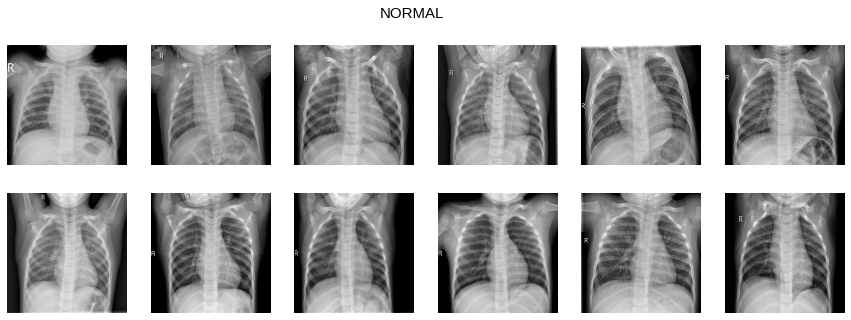

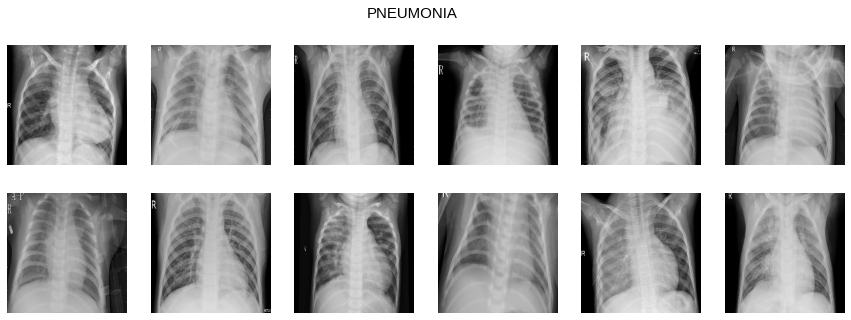

In [0]:
visualize_samples(X_train[y_train==0], rows=2, cols=6, title='NORMAL')
visualize_samples(X_train[y_train==1], rows=2, cols=6, title='PNEUMONIA')

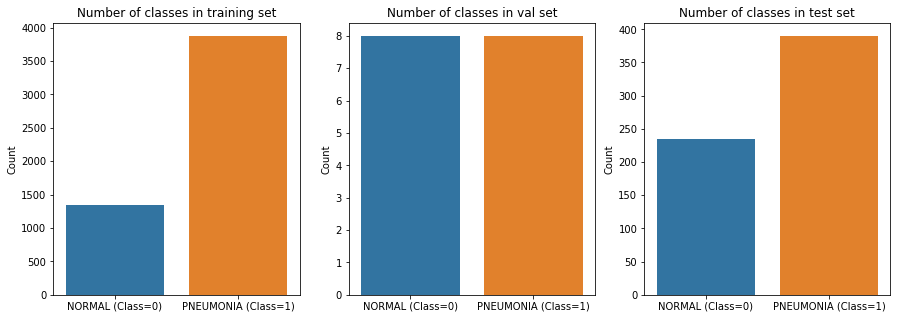

In [0]:
plt.figure(figsize=(15, 5))
for i, (labels, set_name) in enumerate(zip([y_train, y_val, y_test], ['training', 'val', 'test'])):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=['NORMAL (Class=0)', 'PNEUMONIA (Class=1)'], 
                y=list(Counter(labels).values()))
    plt.ylabel("Count")
    plt.title("Number of classes in {} set".format(set_name))
plt.show()

## Augmentation Pipeline and Batch Preparation

In [0]:
# Defining an augmentation pipeline with Albumentations
aug_pipeline = A.Compose([
    A.OneOf([
        A.HorizontalFlip(p=.5),
        A.GaussNoise(),
    ], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.2, 
                       rotate_limit=45, p=0.2),
    A.OneOf([
        A.VerticalFlip(p=.5),
        A.OpticalDistortion(p=0.6),
        A.GridDistortion(p=.3),
        A.IAAPiecewiseAffine(p=0.4),
    ], p=0.6),
    ToTensor(),
], p=.5)

In [0]:
# Declaring custom Pytorch Dataset subclasses

class TrainDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform 
  
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        target = torch.tensor(self.labels[index], dtype=torch.long)
        if self.transform is not None:
            image = self.transform(image=self.images[index])['image']
        else:
            image = torch.FloatTensor(self.images[index].transpose(2, 1, 0)).to(device)
        return image, target
        

class ValDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)
  
    def __getitem__(self, index):
        image = self.transform(self.images[index])
        target = torch.tensor(self.labels[index], dtype=torch.long)
        return image, target
    

class TestDataset(Dataset):
    def __init__(self, images, transform):
        self.images = images
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.transform(self.images[index])
        return image.to(device)

In [0]:
traindata_params = dict(batch_size=32,
                        num_workers=6,
                        pin_memory=False)

valdata_params = dict(batch_size=6,
                      num_workers=6,
                      shuffle=True,
                      pin_memory=False)

testdata_params = dict(batch_size=1, 
                       shuffle=False, 
                       pin_memory=False)


# Sampling strategy to preserve class weights in each mini-batch
class_sample_counts = list(Counter(y_train).values())
weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
samples_weights = weights[y_train]
sampler = WeightedRandomSampler(weights=samples_weights, 
                                num_samples=len(samples_weights),
                                replacement=True)

# Creating DataLoaders for training, validation and test sets.
train_data = TrainDataset(images=X_train, labels=y_train, transform=aug_pipeline)
train_loader = DataLoader(train_data, **traindata_params, sampler=sampler)

val_data = ValDataset(images=X_val, labels=y_val, transform=transforms.ToTensor())
val_loader = DataLoader(val_data, **valdata_params)

test_dataset = TestDataset(images=X_test, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, **testdata_params)

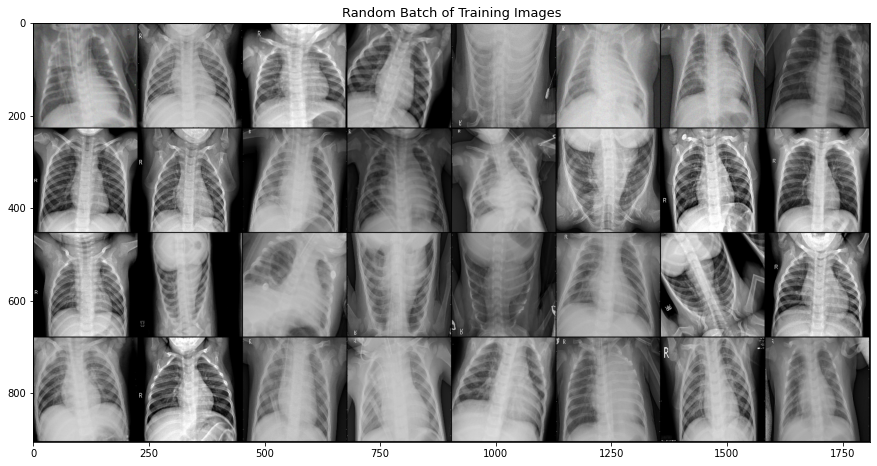

In [0]:
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(15, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("Random Batch of Training Images", size=13)
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

## Model Definition and Training

In [0]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
            self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, groups=64, kernel_size=(3, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, groups=128, kernel_size=(3, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
          )

        self.dense_layers = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(7680, 1046),
            nn.ReLU(inplace=True),
            nn.Dropout(p=.3),
            nn.Linear(1046, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=.3),
            nn.Linear(256, 2)
          )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.shape[0], -1)
        x = self.dense_layers(x)
        return x

In [0]:
model = Network().to(device)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)

In [0]:
def visualize_eval(train_loss, val_loss) :
    plt.figure(figsize=(5, 5))
    epochs = range(1, 1 + len(train_loss)) 
    plt.style.use('seaborn-white')
    plt.plot(epochs, train_loss, color='blue', label='Train loss')
    plt.plot(epochs, val_loss, color='orange', label='Valdation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [0]:
def fit(model, train_loader=None, val_loader=None, epochs=15):
    torch.manual_seed(0)
    train_loss = []
    val_loss = []
    for epoch in range(1, epochs+1):
        print('\nEpoch {}/{}'.format(epoch, epochs))
        training_loss = []
        validation_loss = []
    
        for batch_x, batch_y in tqdm(train_loader):
            train_x, train_y = batch_x.to(device), batch_y.to(device)
            outputs = model(train_x) # forward propagation
            loss = criterion(outputs, train_y) # compute the loss
            training_loss.append(loss.item())
            loss.backward() # backpropagation 
            optimizer.step() # optimization step
            optimizer.zero_grad() # set parameter gradients to zero
    
        with torch.set_grad_enabled(False):
            for val_batch_x, val_batch_y in val_loader:
                val_x, val_y = val_batch_x.to(device), val_batch_y.to(device)
                val_outputs = model(val_x)
                loss_val = criterion(val_outputs, val_y)
                validation_loss.append(loss_val.item())

        training_loss = np.average(training_loss)
        validation_loss = np.average(validation_loss)
        train_loss.append(training_loss)
        val_loss.append(validation_loss)
        print('\ttrain_loss: %.4f\t\n' % training_loss, '\tval_loss: %.4f\t' % validation_loss)
    visualize_eval(train_loss, val_loss)


Epoch 1/15



	train_loss: 0.3577	
 	val_loss: 0.6559	

Epoch 2/15



	train_loss: 0.2110	
 	val_loss: 0.4930	

Epoch 3/15



	train_loss: 0.1962	
 	val_loss: 0.5729	

Epoch 4/15



	train_loss: 0.1692	
 	val_loss: 0.5675	

Epoch 5/15



	train_loss: 0.1714	
 	val_loss: 0.3622	

Epoch 6/15



	train_loss: 0.1584	
 	val_loss: 0.3311	

Epoch 7/15



	train_loss: 0.1612	
 	val_loss: 0.1220	

Epoch 8/15



	train_loss: 0.1489	
 	val_loss: 0.3483	

Epoch 9/15



	train_loss: 0.1414	
 	val_loss: 0.2356	

Epoch 10/15



	train_loss: 0.1341	
 	val_loss: 0.1787	

Epoch 11/15



	train_loss: 0.1299	
 	val_loss: 0.2559	

Epoch 12/15



	train_loss: 0.1425	
 	val_loss: 0.2828	

Epoch 13/15



	train_loss: 0.1311	
 	val_loss: 0.2406	

Epoch 14/15



	train_loss: 0.1383	
 	val_loss: 0.3005	

Epoch 15/15



	train_loss: 0.1218	
 	val_loss: 0.1246	


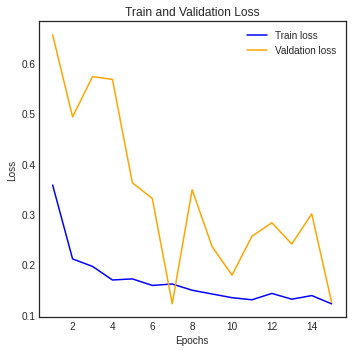

In [0]:
fit(model=model, 
    train_loader=train_loader, 
    val_loader=val_loader)

## Evaluation

We will use the following metrics to evaluate the model:

- F1-Score
- Area under ROC-curve (ROC AUC)
- Recall 
- Precision
- Balanced Accuracy

In [0]:
model.eval()
test_outputs = torch.zeros((len(X_test), 2), dtype=torch.float, device=device)
with torch.set_grad_enabled(False):
    for i, test_batch_x in enumerate(test_loader):
        outputs = test_batch_x.to(device)
        test_outputs[i] = model(outputs)

_, predicted = torch.max(test_outputs, 1)
pred_classes = predicted.to('cpu').detach().numpy()

<Figure size 432x288 with 0 Axes>

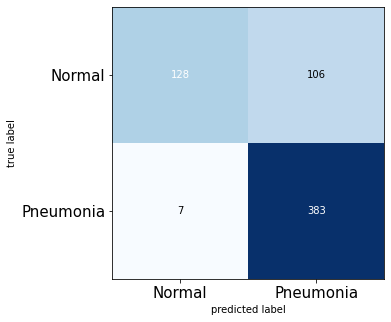

In [12]:
cm  = confusion_matrix(y_test, pred_classes)
plt.figure()
plot_confusion_matrix(cm,figsize=(15, 5), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=15)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=15)
plt.show()

In [13]:
f1score = f1_score(y_test, pred_classes)
rec = recall_score(y_test, pred_classes)
pre = precision_score(y_test, pred_classes) 
bal_acc = balanced_accuracy_score(y_test, pred_classes)
roc_auc = roc_auc_score(y_test, pred_classes)
scores = [f1score, roc_auc, rec, pre, bal_acc]

scoring_df = pd.DataFrame({'Metric' : ["F1-Score", "ROC AUC", "Recall", "Precision", "Balanced Acc"],
                           "Score": scores})

pd.options.display.float_format = '{:,.2f}'.format
scoring_df

,Metric,Score
0,F1-Score,0.87
1,ROC AUC,0.76
2,Recall,0.98
3,Precision,0.78
4,Balanced Acc,0.76
